# Master MLDS 2018/2019 - Projet Deep Learning

## Objectif: Explorer, visualiser et classifier le jeu de données Fashion-MNIST

## Author: Jamal Aourraz

### Préparation de données Fashion-MNIST

In [2]:
##All imports
import tensorflow as tf
from keras.datasets import fashion_mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [4]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [5]:
X=np.reshape(x_train,(x_train.shape[0],28*28))

In [6]:
XS = StandardScaler().fit_transform(X)

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### PCA

In [10]:
#pca = PCA(n_components=2)
pca = PCA(.95)
pca_result = pca.fit_transform(XS)

In [11]:
pca.n_components_

256

In [12]:
pd.DataFrame([sorted(pca.explained_variance_ratio_[0:11],reverse=True)],
             columns=['PC'+str(i) for i in range(11)])

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0.220835,0.144146,0.054612,0.050887,0.040549,0.030195,0.027475,0.023137,0.016926,0.01318,0.011701


In [13]:
sum(pca.explained_variance_ratio_[0:11])

0.6336441675813793

In [14]:
principalDf = pd.DataFrame(data = pca_result , columns = ['PC'+str(i) for i in range(pca.n_components_)])

In [15]:
finalDf = pd.concat([principalDf, pd.DataFrame(y_train, columns=['Target'])], axis = 1)

In [16]:
finalDf.shape

(60000, 257)

In [17]:
np.unique(finalDf.loc[:,'Target'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [19]:
targets = np.unique(y_train)
colors = ['r', 'g', 'b','g','y','violet','maroon','cyan','k','orange']

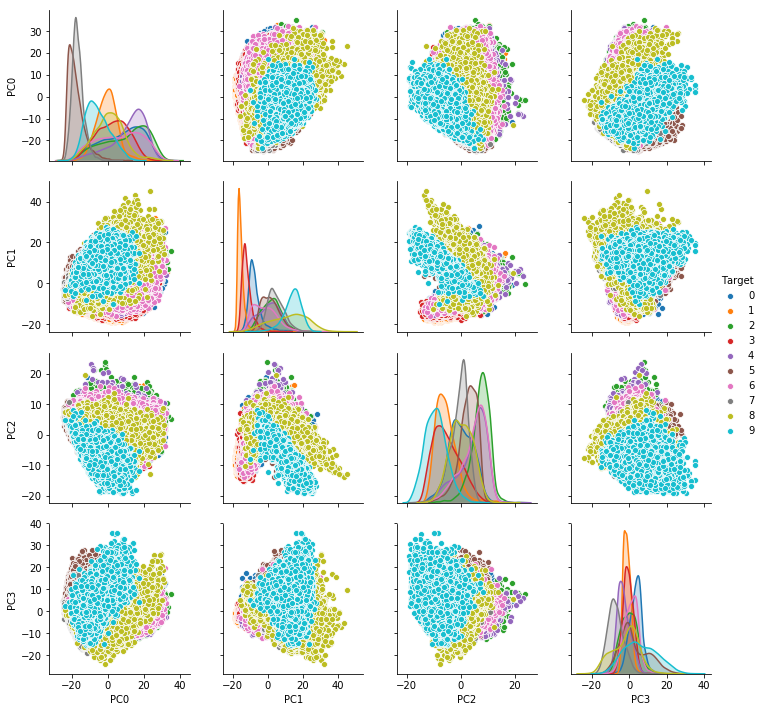

In [21]:
sns.pairplot(finalDf, vars=["PC0","PC1","PC2","PC3"], hue="Target")

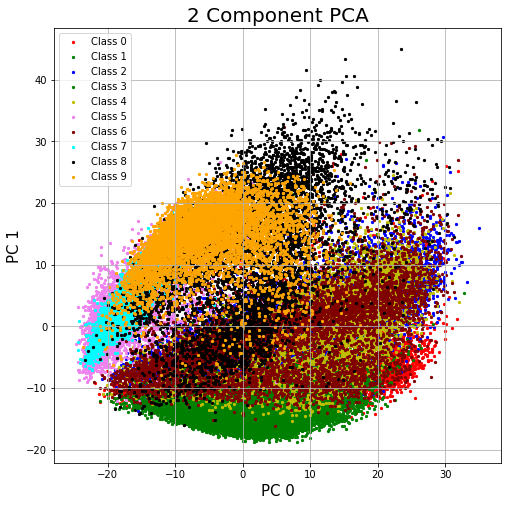

In [22]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 0', fontsize = 15)
ax.set_ylabel('PC 1', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC0']
               , finalDf.loc[indicesToKeep, 'PC1']
               , c = color
               , s = 5)
ax.legend(['Class '+str(i) for i in targets])
ax.grid()

In [23]:
type(finalDf['Target'][1])

numpy.uint8

<Figure size 432x288 with 0 Axes>

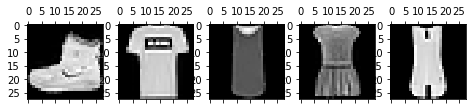

In [24]:
plt.gray()
fig2 = plt.figure( figsize=(16,7) )
for i in range(0,5):
    ax = fig2.add_subplot(3,10,i+1)
    ax.matshow(X[i].reshape((28,28)))
plt.show()

In [25]:
X_reconstructed=pca.inverse_transform(pca_result)

In [26]:
X_reconstructed.shape

(60000, 784)

<Figure size 432x288 with 0 Axes>

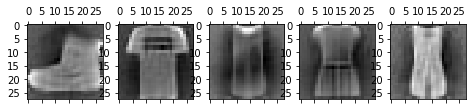

In [27]:
plt.gray()
fig2 = plt.figure( figsize=(16,7) )
for i in range(0,5):
    ax = fig2.add_subplot(3,10,i+1)
    ax.matshow(X_reconstructed[i].reshape((28,28)))
plt.show()

# t-SNE

In [34]:
from MulticoreTSNE import MulticoreTSNE as TSNE

Package Multicore TSNE: https://github.com/DmitryUlyanov/Multicore-TSNE

In [35]:
#Display  Multicore TSNE Steps
%load_ext wurlitzer

In [36]:
tsne = TSNE(n_jobs=4)
tsne_result = tsne.fit_transform(XS)

In [26]:
tsne_result.shape

(60000, 2)

In [39]:
tsneDf = pd.concat([pd.DataFrame(tsne_result,columns=["TSNE 0","TSNE 1"]), pd.DataFrame(y_train, columns=['Target'])], axis = 1)

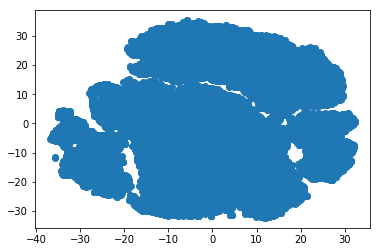

In [40]:
vis_x = tsne_result[:, 0]
vis_y = tsne_result[:, 1]
plt.scatter(vis_x, vis_y)
plt.clim(-0.5, 9.5)
plt.show()

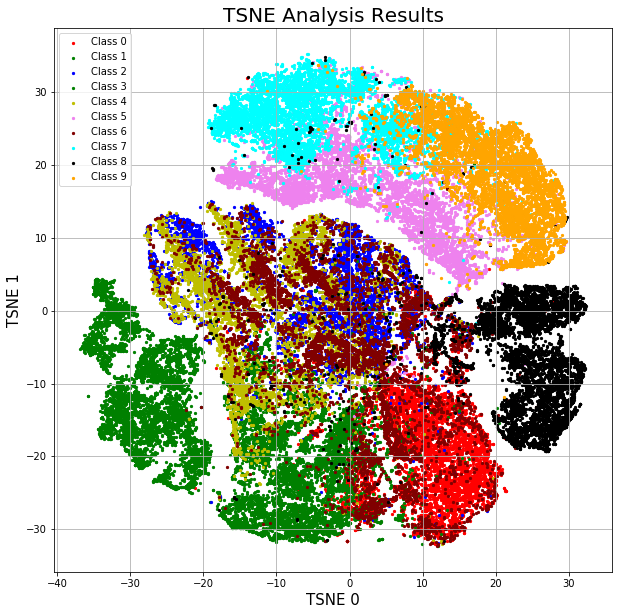

In [41]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('TSNE 0', fontsize = 15)
ax.set_ylabel('TSNE 1', fontsize = 15)
ax.set_title('TSNE Analysis Results', fontsize = 20)
for target, color in zip(targets,colors):
    indicesToKeep = tsneDf['Target'] == target
    ax.scatter(tsneDf.loc[indicesToKeep, 'TSNE 0']
               , tsneDf.loc[indicesToKeep, 'TSNE 1']
               , c = color
               , s = 5)
ax.legend(['Class '+str(i) for i in targets])
ax.grid()

### Autoencoders

In [42]:
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape

In [43]:
X_train=np.reshape(x_train,(x_train.shape[0],28*28))/255.
X_test=np.reshape(x_test,(x_test.shape[0],28*28))/255.

In [44]:
input_size = 784
hidden_size_1 = 128
hidden_size_2 = 64
code_size = 32
#input
x = Input(shape=(input_size,))
#encoders
hidden_1 = Dense(hidden_size_1, activation='relu')(x)
hidden_2 = Dense(hidden_size_2, activation='relu')(hidden_1)
#latent layer
latent = Dense(code_size, activation='relu')(hidden_2)
#decoders
h2 = Dense(hidden_size_2, activation='relu')(latent)
h1 = Dense(hidden_size_1, activation='relu')(h2)
#output
r = Dense(input_size, activation='sigmoid')(h1)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

In [45]:
encoder = Model(inputs=x,outputs=latent)
encoder.compile(optimizer='adam', loss='mse')

In [ ]:
epochs = 100
batch_size = 100
history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, 
                          validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100


2018-12-21 23:28:15.934388: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


60000/60000 [==============================] - 11s 177us/step - loss: 0.0343 - val_loss: 0.0214
Epoch 2/100
60000/60000 [==============================] - 10s 169us/step - loss: 0.0193 - val_loss: 0.0179
Epoch 3/100
60000/60000 [==============================] - 10s 160us/step - loss: 0.0170 - val_loss: 0.0164
Epoch 4/100
60000/60000 [==============================] - 9s 150us/step - loss: 0.0156 - val_loss: 0.0151
Epoch 5/100
60000/60000 [==============================] - 9s 150us/step - loss: 0.0147 - val_loss: 0.0144
Epoch 6/100
60000/60000 [==============================] - 9s 142us/step - loss: 0.0140 - val_loss: 0.0137
Epoch 7/100
60000/60000 [==============================] - 9s 155us/step - loss: 0.0135 - val_loss: 0.0133
Epoch 8/100
60000/60000 [==============================] - 9s 153us/step - loss: 0.0130 - val_loss: 0.0130
Epoch 9/100
60000/60000 [==============================] - 9s 153us/step - loss: 0.0127 - val_loss: 0.0128
Epoch 10/100
60000/60000 [====================

In [56]:
decoded_result = autoencoder.predict(X_test)

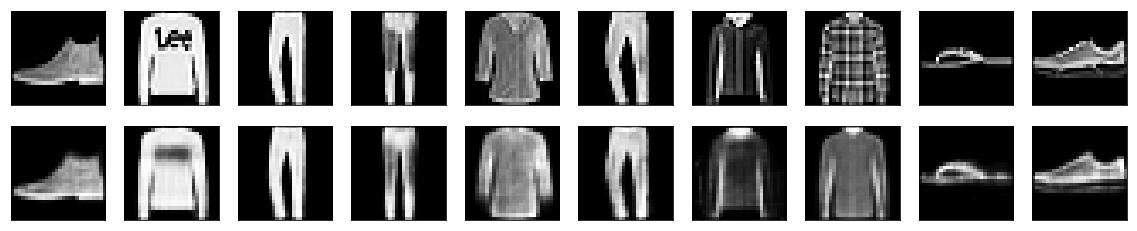

In [57]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_result[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

dict_keys(['val_loss', 'loss'])


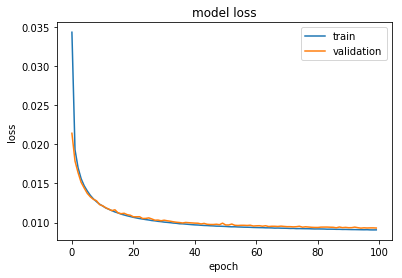

In [58]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Kmeans

In [59]:
decoded_result.shape

(10000, 784)

In [60]:
encoded_result = encoder.predict(X_train)

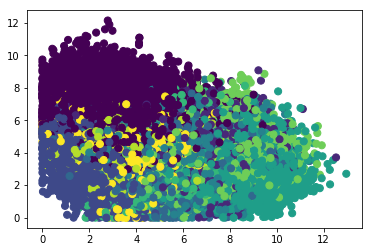

In [61]:
from sklearn.cluster import KMeans
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=100, n_jobs=-1, random_state=5)
Y_kmeans = kmeans.fit(encoded_result)
Y_kmeans = Y_kmeans.labels_
plt.scatter(encoded_result[:,0], encoded_result[:,1], c=Y_kmeans, s=50, cmap='viridis')

### t-SNE on encoded data

In [62]:
from sklearn.manifold import TSNE

In [63]:
tsne = TSNE(n_components=2, init='random', random_state=5, learning_rate=200,
                     method='barnes_hut', n_iter=300, verbose=2, perplexity=30.0)
tsne_result_ecnoded = tsne.fit_transform(encoded_result)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.224s...
[t-SNE] Computed neighbors for 60000 samples in 135.370s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

In [64]:
tsne_result_ecnoded.shape

(60000, 2)

In [65]:
tsne_ecnoded_df=pd.concat([pd.DataFrame(tsne_result_ecnoded,
                         columns=["TSNE 0","TSNE 1"]), pd.DataFrame(y_train, 
                         columns=['Target'])], axis = 1)

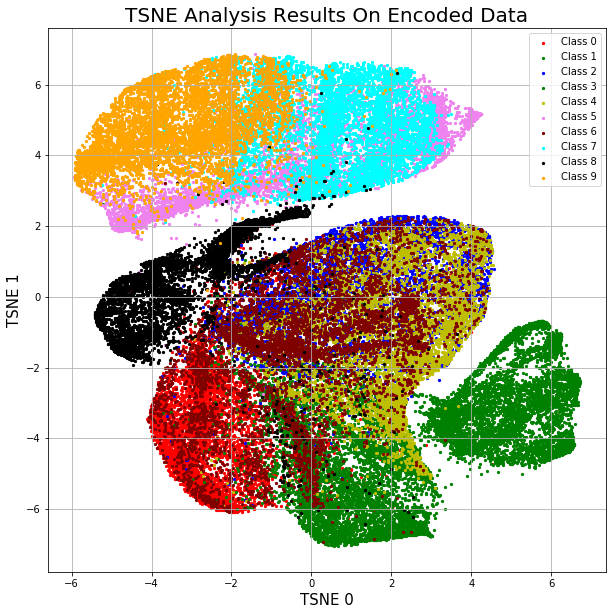

In [66]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('TSNE 0', fontsize = 15)
ax.set_ylabel('TSNE 1', fontsize = 15)
ax.set_title('TSNE Analysis Results On Encoded Data', fontsize = 20)
for target, color in zip(targets,colors):
    indicesToKeep = tsne_ecnoded_df['Target'] == target
    ax.scatter(tsne_ecnoded_df.loc[indicesToKeep, 'TSNE 0']
               , tsne_ecnoded_df.loc[indicesToKeep, 'TSNE 1']
               , c = color
               , s = 5)
ax.legend(['Class '+str(i) for i in targets])
ax.grid()